In [60]:
import  numpy 
from  rdkit.Chem.Draw  import IPythonConsole
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import DataStructs
from rdkit import rdBase
print(rdBase.rdkitVersion)

import time
print(time.asctime())
%pylab inline

2018.03.2
Wed Jun 27 12:55:40 2018
Populating the interactive namespace from numpy and matplotlib


In [61]:

##
 # Functions for providing detailed descriptions of MFP bits # Funct 
#  inspired by some code from from Nadine Schneider 
#
def getSubstructSmi(mol,atomID,radius):
    if radius>0:
        env = Chem.FindAtomEnvironmentOfRadiusN(mol,radius,atomID)
        atomsToUse=[]
        for b in env:
            atomsToUse.append(mol.GetBondWithIdx(b).GetBeginAtomIdx())
            atomsToUse.append(mol.GetBondWithIdx(b).GetEndAtomIdx())
        atomsToUse = list(set(atomsToUse))
    else:
        atomsToUse = [atomID]
        env=None
    symbols = []
    for atom in mol.GetAtoms():
        deg = atom.GetDegree()
        isInRing = atom.IsInRing()
        nHs = atom.GetTotalNumHs()
        symbol = '['+atom.GetSmarts()
        if nHs: 
            symbol += 'H'
            if nHs>1:
                symbol += '%d'%nHs
        if isInRing:
            symbol += ';R'
        else:
            symbol += ';!R'
        symbol += ';D%d'%deg
        symbol += "]"
        symbols.append(symbol)
    smi = Chem.MolFragmentToSmiles(mol,atomsToUse,bondsToUse=env,allHsExplicit=True, allBondsExplicit=True, rootedAtAtom=atomID)
    smi2 = Chem.MolFragmentToSmiles(mol,atomsToUse,bondsToUse=env,atomSymbols=symbols, allBondsExplicit=True, rootedAtAtom=atomID)
    return smi,smi2

In [62]:
# Start by importing some code to allow the depiction to be used:
from IPython.display import SVG
from rdkit.Chem.Draw import rdMolDraw2D

# a function to make it a bit easier. This should probably move to somewhere in
# rdkit.Chem.Draw
def _prepareMol(mol,kekulize):
    mc = Chem.Mol(mol.ToBinary())
    if kekulize:
        try:
            Chem.Kekulize(mc)
        except:
            mc = Chem.Mol(mol.ToBinary())
    if not mc.GetNumConformers():
        rdDepictor.Compute2DCoords(mc)
    return mc
def moltosvg(mol,molSize=(450,200),kekulize=True,drawer=None,**kwargs):
    mc = rdMolDraw2D.PrepareMolForDrawing(mol,kekulize=kekulize)
    if drawer is None:
        drawer = rdMolDraw2D.MolDraw2DSVG(molSize[0],molSize[1])
    drawer.DrawMolecule(mc,**kwargs)
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText()
    # It seems that the svg renderer used doesn't quite hit the spec.
    # Here are some fixes to make it work in the notebook, although I think
    # the underlying issue needs to be resolved at the generation step
    return SVG(svg.replace('svg:',''))

In [63]:
# do a depiction where the atom environment is highlighted normally and the central atom
# is highlighted in blue
def getSubstructDepiction(mol,atomID,radius,molSize=(450,200)):
    if radius>0:
        env = Chem.FindAtomEnvironmentOfRadiusN(mol,radius,atomID)
        atomsToUse=[]
        for b in env:
            atomsToUse.append(mol.GetBondWithIdx(b).GetBeginAtomIdx())
            atomsToUse.append(mol.GetBondWithIdx(b).GetEndAtomIdx())
        atomsToUse = list(set(atomsToUse))       
    else:
        atomsToUse = [atomID]
        env=None
    return moltosvg(mol,molSize=molSize,highlightAtoms=atomsToUse,highlightAtomColors={atomID:(0.3,0.3,1)})
def depictBit(bitId,mol,molSize=(450,200)):
    info={}
    fp = AllChem.GetMorganFingerprintAsBitVect(mol,radius=3,nBits=4096,bitInfo=info)
    aid,rad = info[bitId][0]
    return getSubstructDepiction(mol,aid,rad,molSize=molSize)

In [64]:
bz = Chem.MolFromSmiles('c1ccccc1')
fp_bz = AllChem.GetMorganFingerprintAsBitVect(bz,radius=3,nBits=4096)
pyr = Chem.MolFromSmiles('c1ccccn1')
fp_pyr = AllChem.GetMorganFingerprintAsBitVect(pyr,radius=3,nBits=4096)
print("Similarity:",DataStructs.TanimotoSimilarity(fp_bz,fp_pyr))

Similarity: 0.2727272727272727


In [65]:
bi_bz = {}
fp_bz = AllChem.GetMorganFingerprintAsBitVect(bz,radius=3,nBits=4096,bitInfo=bi_bz)
bi_pyr = {}
fp_pyr = AllChem.GetMorganFingerprintAsBitVect(pyr,radius=3,nBits=4096,bitInfo=bi_pyr)

In [66]:
bi_bz

{389: ((2, 2), (3, 2), (1, 2), (0, 2), (5, 2), (4, 2)),
 1088: ((1, 1), (2, 1), (3, 1), (4, 1), (0, 1), (5, 1)),
 1232: ((0, 3),),
 3921: ((0, 0), (1, 0), (2, 0), (3, 0), (4, 0), (5, 0))}

In [67]:

info_bz = []
for bitId,atoms in bi_bz.items():
    exampleAtom,exampleRadius = atoms[0]
    description = getSubstructSmi(bz,exampleAtom,exampleRadius)
    info_bz.append((bitId,exampleRadius,description[0],description[1]))
print(info_bz)

[(389, 2, '[cH](:[cH]:[cH]):[cH]:[cH]', '[cH;R;D2](:[cH;R;D2]:[cH;R;D2]):[cH;R;D2]:[cH;R;D2]'), (1088, 1, '[cH](:[cH]):[cH]', '[cH;R;D2](:[cH;R;D2]):[cH;R;D2]'), (1232, 3, '[cH]1:[cH]:[cH]:[cH]:[cH]:[cH]:1', '[cH;R;D2]1:[cH;R;D2]:[cH;R;D2]:[cH;R;D2]:[cH;R;D2]:[cH;R;D2]:1'), (3921, 0, '[cH]', '[cH;R;D2]')]


In [68]:

info_pyr = []
for bitId,atoms in bi_pyr.items():
    exampleAtom,exampleRadius = atoms[0]
    description = getSubstructSmi(pyr,exampleAtom,exampleRadius)
    info_pyr.append((bitId,exampleRadius,description[0],description[1]))
print(info_pyr)

[(378, 0, '[n]', '[n;R;D2]'), (389, 2, '[cH](:[cH]:[cH]):[cH]:[cH]', '[cH;R;D2](:[cH;R;D2]:[cH;R;D2]):[cH;R;D2]:[cH;R;D2]'), (1088, 1, '[cH](:[cH]):[cH]', '[cH;R;D2](:[cH;R;D2]):[cH;R;D2]'), (2431, 2, '[n](:[cH]:[cH]):[cH]:[cH]', '[n;R;D2](:[cH;R;D2]:[cH;R;D2]):[cH;R;D2]:[cH;R;D2]'), (2485, 2, '[cH](:[cH]:[cH]):[n]:[cH]', '[cH;R;D2](:[cH;R;D2]:[cH;R;D2]):[n;R;D2]:[cH;R;D2]'), (3066, 3, '[n]1:[cH]:[cH]:[cH]:[cH]:[cH]:1', '[n;R;D2]1:[cH;R;D2]:[cH;R;D2]:[cH;R;D2]:[cH;R;D2]:[cH;R;D2]:1'), (3203, 2, '[cH](:[cH]:[cH]):[cH]:[n]', '[cH;R;D2](:[cH;R;D2]:[cH;R;D2]):[cH;R;D2]:[n;R;D2]'), (3651, 1, '[n](:[cH]):[cH]', '[n;R;D2](:[cH;R;D2]):[cH;R;D2]'), (3914, 1, '[cH](:[cH]):[n]', '[cH;R;D2](:[cH;R;D2]):[n;R;D2]'), (3921, 0, '[cH]', '[cH;R;D2]')]


In [69]:
collection = {}
for bid,rad,smi,sma in info_bz:
    collection[bid] = [bid,rad,smi,sma,'','']
for bid,rad,smi,sma in info_pyr:
    if bid not in collection:
        collection[bid] = [bid,rad,'','','','']
    collection[bid][-2] = smi
    collection[bid][-1] = sma

In [70]:

import  pandas  as pd
pd.options.display.width=100000  # options to make sure our wide columns display properly# option 
pd.options.display.max_colwidth=1000

In [71]:
df = pd.DataFrame(list(collection.values()),columns=('Bit','radius','smi_bz','sma_bz','smi_pyr','sma_pyr'))
df.sort_values(by='radius')

,Bit,radius,smi_bz,sma_bz,smi_pyr,sma_pyr
3,3921,0,[cH],[cH;R;D2],[cH],[cH;R;D2]
4,378,0,,,[n],[n;R;D2]
1,1088,1,[cH](:[cH]):[cH],[cH;R;D2](:[cH;R;D2]):[cH;R;D2],[cH](:[cH]):[cH],[cH;R;D2](:[cH;R;D2]):[cH;R;D2]
9,3651,1,,,[n](:[cH]):[cH],[n;R;D2](:[cH;R;D2]):[cH;R;D2]
10,3914,1,,,[cH](:[cH]):[n],[cH;R;D2](:[cH;R;D2]):[n;R;D2]
0,389,2,[cH](:[cH]:[cH]):[cH]:[cH],[cH;R;D2](:[cH;R;D2]:[cH;R;D2]):[cH;R;D2]:[cH;R;D2],[cH](:[cH]:[cH]):[cH]:[cH],[cH;R;D2](:[cH;R;D2]:[cH;R;D2]):[cH;R;D2]:[cH;R;D2]
5,2431,2,,,[n](:[cH]:[cH]):[cH]:[cH],[n;R;D2](:[cH;R;D2]:[cH;R;D2]):[cH;R;D2]:[cH;R;D2]
6,2485,2,,,[cH](:[cH]:[cH]):[n]:[cH],[cH;R;D2](:[cH;R;D2]:[cH;R;D2]):[n;R;D2]:[cH;R;D2]
8,3203,2,,,[cH](:[cH]:[cH]):[cH]:[n],[cH;R;D2](:[cH;R;D2]:[cH;R;D2]):[cH;R;D2]:[n;R;D2]
2,1232,3,[cH]1:[cH]:[cH]:[cH]:[cH]:[cH]:1,[cH;R;D2]1:[cH;R;D2]:[cH;R;D2]:[cH;R;D2]:[cH;R;D2]:[cH;R;D2]:1,,


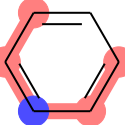

In [72]:
depictBit(389,bz,molSize=(125,125))

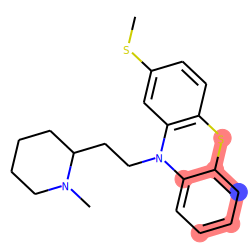

In [73]:
s1 = Chem.MolFromSmiles('CN1CCCCC1CCN2C3=CC=CC=C3SC4=C2C=C(C=C4)SC')
depictBit(397,s1,molSize=(250,250))

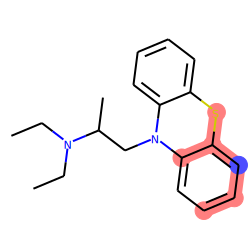

In [74]:
s2 = Chem.MolFromSmiles('CCN(CC)C(C)CN1C2=CC=CC=C2SC3=CC=CC=C31')
depictBit(397,s2,molSize=(250,250))

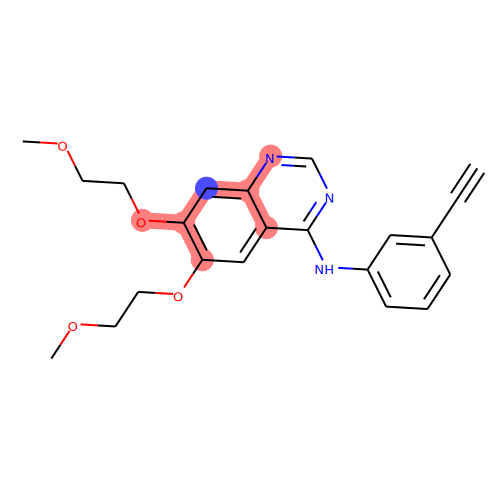

In [76]:
s3 = Chem.MolFromSmiles('COCCOC1=C(C=C2C(=C1)C(=NC=N2)NC3=CC=CC(=C3)C#C)OCCOC')
depictBit(2828,s3,molSize=(500,500))

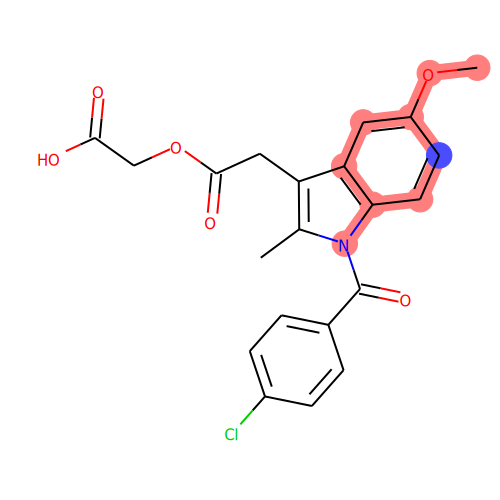

In [77]:
s4 = Chem.MolFromSmiles('CC1=C(C2=C(N1C(=O)C3=CC=C(C=C3)Cl)C=CC(=C2)OC)CC(=O)OCC(=O)O')
depictBit(343,s4,molSize=(500,500))